In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from deepmotion import registration
from deepmotion.simulations import simu3d
from deepmotion.utils import montage, io_utils
import pandas as pd
from os import listdir
from os.path import isdir
from nilearn.masking import compute_epi_mask

In [3]:
# load data
mypath = '/home/cdansereau/data/cobre/cobre_ln_cor/HC/'
listdir(mypath)


def load_subj(source_folder):
    if not isdir(source_folder):
        print 'Error folder does not exist', source_folder
    else: 
        #df = pd.read_csv(source_folder+'motion_params.csv',index_col=0)
        #vol_nii = nib.load(source_folder+'rest_ln.nii.gz')
        dic_data = io_utils.load(source_folder+ 'data_ln.hd5')
        
    #print vol_nii.shape
    #plt.plot(df.values)
    
    return dic_data
    
dic_data = load_subj('/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040123/')

('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])


In [3]:
dic_data.keys()

[u'transfs', u'v2w_affine', u'motion_params', u'vol']

In [4]:

source_path = '/home/cdansereau/data/cobre/cobre_ln_cor/HC/'

m_field       = []
images        = []
images_raw    = []
motion_params = []
all_v2w       = []
zerooutofmask = True

for patientid in listdir(source_path):
#for patientid in listdir(source_path)[:50]:
    print source_path+patientid
    dic_data = load_subj(source_path+patientid+'/')
    
    # compute motion field
    m_field.append(registration.displacement_field(dic_data['v2w_affine'], 
                                              dic_data['motion_params'], 
                                              dic_data['vol'].shape[:3]))
    
    m_field[-1] = m_field[-1][1:,...]-m_field[-1][:-1,...]
    # stack images
    img_ = np.swapaxes(dic_data['vol'][np.newaxis,...],0,-1)
    images_raw.append(img_)
    
    # express in % of the baseline
    img_dm = np.nan_to_num((dic_data['vol']-dic_data['vol'].mean(-1)[...,np.newaxis])/dic_data['vol'].mean(-1)[...,np.newaxis])
    
    if zerooutofmask:
        img_nifti = nib.Nifti1Image(dic_data['vol'], dic_data['v2w_affine'])
        mask_ = compute_epi_mask(img_nifti).get_data()
        img_dm[mask_!=True] = 0
        #m_field[-1][mask_!=True] = 0
        
    images.append(np.swapaxes(img_dm[np.newaxis,...,1:],0,-1))
    
    # stack motion params and v2w affine transforms
    motion_params.append(dic_data['motion_params'])
    all_v2w.append(dic_data['v2w_affine'])
    
    
m_field = np.vstack(m_field)[...,:32,:]
images = np.vstack(images)[...,:32,:]
motion_params = np.vstack(motion_params)
all_v2w = np.stack(all_v2w)   
    

/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040033
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])

/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide



/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040134
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040076
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040127
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040057
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040020
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040115
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040018
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdanse

('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040131
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040017
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040058
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040052
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040128
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040125
('List of arrays in this file: ', [u'motion_params', u'transfs', u'v2w_affine', u'vol'])
/home/cdansereau/data/cobre/cobre_ln_cor/HC/0040055
('List of arr

In [13]:
print images.shape
print m_field.shape

(11026, 64, 64, 32, 1)
(11026, 64, 64, 32, 3)


In [ ]:
mask_.shape

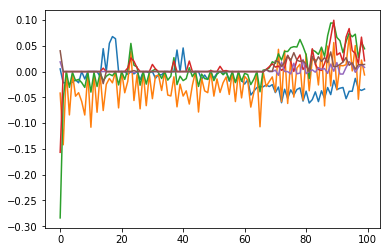

In [141]:
plt.plot(motion_params[:100,:])

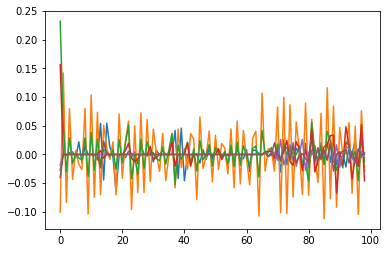

In [95]:
plt.plot(motion_params[1:100,:]-motion_params[:99,:])

In [83]:
motion_params[0,:]

array([ 0.00515436, -0.04178999, -0.28397729, -0.15668652,  0.01876889,
        0.04028015])

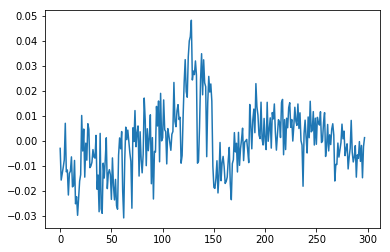

In [96]:
plt.plot(images[:,25,20,15,0])

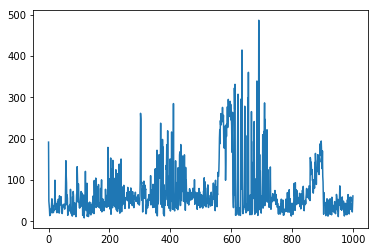

In [284]:
plt.plot(images[:1000,30,20,:,0].max(1))

In [108]:
motion_params[0,:]

array([ 0.00515436, -0.04178999, -0.28397729, -0.15668652,  0.01876889,
        0.04028015])

In [131]:
m_field[mask_[np.newaxis,:,:,:,np.newaxis]!=1]=0

/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 1
  """Entry point for launching an IPython kernel.


IndexError: index 32 is out of bounds for axis 3 with size 32

In [134]:
mask_[np.newaxis,:,:,:,np.newaxis].shape

(1, 64, 64, 33, 1)

In [111]:
dic_data['motion_params'][0,:]=[10,0,0,0,0,0]

m_field = registration.displacement_field(dic_data['v2w_affine'], 
                              dic_data['motion_params'], 
                              dic_data['vol'].shape[:3])


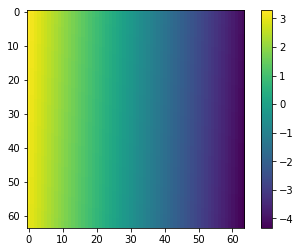

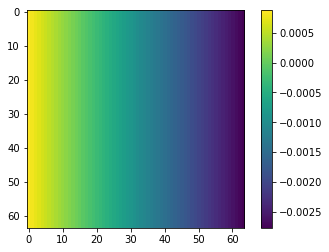

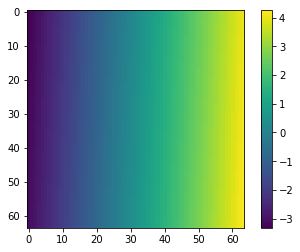

In [140]:

plt.figure()
plt.imshow(m_field[0,:,:,15,0])
plt.colorbar()
plt.figure()
plt.imshow(m_field[1,:,:,15,0])
plt.colorbar()
plt.figure()
plt.imshow(m_field[1,:,:,15,2]-m_field[0,:,:,15,0])
plt.colorbar()

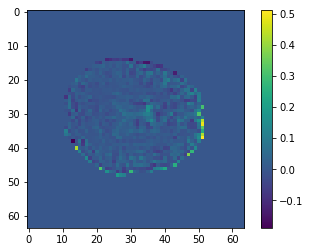

In [124]:
plt.figure()
plt.imshow(img_dm[:,:,15,0])
plt.colorbar()

In [123]:
img_dm.shape

(64, 64, 33, 150)

[<tf.Tensor 'gradients_12/split_6_grad/concat:0' shape=(?, 32, 32, 16, 256) dtype=float32>, None, None]
('Batch', 0, 'Train loss', 6.3981047, 4.4715972, 1.9265075)
('Batch', 32, 'Train loss', 5.6176672, 4.1472936, 1.4703737)
('Batch', 64, 'Train loss', 3.8028255, 2.5973723, 1.205453)
('Batch', 96, 'Train loss', 3.0894654, 1.7546358, 1.3348296)
('Batch', 128, 'Train loss', 2.2271461, 1.3746428, 0.85250318)
('Batch', 160, 'Train loss', 1.7013853, 1.0667058, 0.6346795)
('Batch', 192, 'Train loss', 1.6181062, 1.1222556, 0.49585071)
('Batch', 224, 'Train loss', 0.89924943, 0.51849914, 0.38075033)
('Batch', 256, 'Train loss', 0.70465326, 0.42308316, 0.28157014)
('Batch', 288, 'Train loss', 0.60831696, 0.39227808, 0.2160389)
('Batch', 320, 'Train loss', 0.68701494, 0.16704296, 0.51997197)
('Epoch', 0)
('Train loss', 0.28470242, 'Val loss', 0.3177377)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.38262156, 0.1205

('Batch', 0, 'Train loss', 0.14878894, 0.0017412188, 0.14704773)
('Batch', 32, 'Train loss', 0.0029525119, 0.0010594311, 0.0018930807)
('Batch', 64, 'Train loss', 0.012946237, 0.001007197, 0.011939039)
('Batch', 96, 'Train loss', 0.34777567, 0.0019821753, 0.34579349)
('Batch', 128, 'Train loss', 0.021995205, 0.0014732821, 0.020521924)
('Batch', 160, 'Train loss', 0.0040956545, 0.00093956979, 0.0031560848)
('Batch', 192, 'Train loss', 0.0032930421, 0.0011342188, 0.0021588232)
('Batch', 224, 'Train loss', 0.005224803, 0.0009576474, 0.0042671557)
('Batch', 256, 'Train loss', 0.0041525252, 0.00091773691, 0.0032347885)
('Batch', 288, 'Train loss', 0.0036474264, 0.0010835703, 0.0025638561)
('Batch', 320, 'Train loss', 0.38070202, 0.0020120128, 0.37869)
('Epoch', 9)
('Train loss', 0.0040550297, 'Val loss', 0.002971939)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14841039, 0.0015758841, 0.14683451)
('Batch', 32

('Epoch', 17)
('Train loss', 0.0025649266, 'Val loss', 0.001623549)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14694181, 0.00092274271, 0.14601907)
('Batch', 32, 'Train loss', 0.0014054035, 0.00063008541, 0.00077531801)
('Batch', 64, 'Train loss', 0.011332515, 0.0005200532, 0.010812461)
('Batch', 96, 'Train loss', 0.3462975, 0.0011393405, 0.34515816)
('Batch', 128, 'Train loss', 0.020309903, 0.000823804, 0.019486099)
('Batch', 160, 'Train loss', 0.0026888559, 0.00052582589, 0.00216303)
('Batch', 192, 'Train loss', 0.0020050765, 0.00070175488, 0.0013033217)
('Batch', 224, 'Train loss', 0.0037835641, 0.00051340758, 0.0032701564)
('Batch', 256, 'Train loss', 0.0023162542, 0.00047242388, 0.0018438302)
('Batch', 288, 'Train loss', 0.0021352898, 0.00066645927, 0.0014688305)
('Batch', 320, 'Train loss', 0.37890109, 0.0012739727, 0.37762713)
('Epoch', 18)
('Train loss', 0.002504566, 'Val loss', 0.0016110745)
M

('Batch', 256, 'Train loss', 0.0019677083, 0.00035367819, 0.0016140302)
('Batch', 288, 'Train loss', 0.0017017849, 0.00054314395, 0.001158641)
('Batch', 320, 'Train loss', 0.37839064, 0.0010532103, 0.37733743)
('Epoch', 26)
('Train loss', 0.0020803518, 'Val loss', 0.0011595573)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14642905, 0.00069717882, 0.14573187)
('Batch', 32, 'Train loss', 0.00098216289, 0.00048509144, 0.00049707142)
('Batch', 64, 'Train loss', 0.010908662, 0.00038216717, 0.010526495)
('Batch', 96, 'Train loss', 0.34584528, 0.00088157237, 0.3449637)
('Batch', 128, 'Train loss', 0.019867335, 0.00062962697, 0.019237708)
('Batch', 160, 'Train loss', 0.0022927145, 0.00039892941, 0.0018937851)
('Batch', 192, 'Train loss', 0.0015329928, 0.00056650233, 0.00096649042)
('Batch', 224, 'Train loss', 0.0032676554, 0.00039445396, 0.0028732014)
('Batch', 256, 'Train loss', 0.0019401686, 0.00034338582, 0.0

('Batch', 160, 'Train loss', 0.0021350125, 0.00034424366, 0.0017907688)
('Batch', 192, 'Train loss', 0.0013412588, 0.00050838449, 0.00083287427)
('Batch', 224, 'Train loss', 0.0030816039, 0.00033498171, 0.0027466221)
('Batch', 256, 'Train loss', 0.0017368573, 0.00028039736, 0.00145646)
('Batch', 288, 'Train loss', 0.0013925862, 0.00047450481, 0.00091808138)
('Batch', 320, 'Train loss', 0.37810758, 0.00091260829, 0.37719497)
('Epoch', 35)
('Train loss', 0.0018431209, 'Val loss', 0.00095189281)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14619759, 0.00059419329, 0.14560339)
('Batch', 32, 'Train loss', 0.0007986321, 0.00042565385, 0.00037297825)
('Batch', 64, 'Train loss', 0.010744737, 0.00031533671, 0.0104294)
('Batch', 96, 'Train loss', 0.34553644, 0.00074320601, 0.34479323)
('Batch', 128, 'Train loss', 0.019621162, 0.00052295817, 0.019098204)
('Batch', 160, 'Train loss', 0.0021098168, 0.00033874778, 0.0

('Batch', 64, 'Train loss', 0.010593048, 0.00027912547, 0.010313923)
('Batch', 96, 'Train loss', 0.34528092, 0.00066621345, 0.34461471)
('Batch', 128, 'Train loss', 0.019513367, 0.00045873068, 0.019054636)
('Batch', 160, 'Train loss', 0.0020104826, 0.00030365225, 0.0017068303)
('Batch', 192, 'Train loss', 0.0011697372, 0.00046916981, 0.00070056738)
('Batch', 224, 'Train loss', 0.0029514097, 0.00029120073, 0.0026602088)
('Batch', 256, 'Train loss', 0.0016365333, 0.00024223117, 0.0013943021)
('Batch', 288, 'Train loss', 0.0012253579, 0.00043037563, 0.00079498219)
('Batch', 320, 'Train loss', 0.37796968, 0.00082961388, 0.37714007)
('Epoch', 44)
('Train loss', 0.0017172934, 'Val loss', 0.00080431538)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.1460827, 0.00052747322, 0.14555523)
('Batch', 32, 'Train loss', 0.00066984748, 0.00035871615, 0.00031113136)
('Batch', 64, 'Train loss', 0.01060502, 0.00027619206, 0.

Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14596826, 0.00048088169, 0.14548738)
('Batch', 32, 'Train loss', 0.0005907641, 0.00032264736, 0.00026811671)
('Batch', 64, 'Train loss', 0.010538899, 0.00025383633, 0.010285063)
('Batch', 96, 'Train loss', 0.34510934, 0.00061307877, 0.34449625)
('Batch', 128, 'Train loss', 0.01940194, 0.00041887452, 0.018983064)
('Batch', 160, 'Train loss', 0.0019365562, 0.00027697717, 0.001659579)
('Batch', 192, 'Train loss', 0.0010593222, 0.00044046715, 0.00061885495)
('Batch', 224, 'Train loss', 0.0028550979, 0.00026743981, 0.0025876581)
('Batch', 256, 'Train loss', 0.0015633173, 0.0002138728, 0.0013494445)
('Batch', 288, 'Train loss', 0.0011116299, 0.00040102639, 0.00071060349)
('Batch', 320, 'Train loss', 0.37780544, 0.00077091111, 0.37703454)
('Epoch', 53)
('Train loss', 0.0016284769, 'Val loss', 0.00073702075)
Model saved in file: /scratch/cdansereau/datasets/deepmotion

('Batch', 288, 'Train loss', 0.0010361138, 0.00038307, 0.00065304385)
('Batch', 320, 'Train loss', 0.37776458, 0.00073644263, 0.37702814)
('Epoch', 61)
('Train loss', 0.0015673762, 'Val loss', 0.00067536748)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14592116, 0.00045319306, 0.14546797)
('Batch', 32, 'Train loss', 0.00053386384, 0.00029316539, 0.00024069847)
('Batch', 64, 'Train loss', 0.010445169, 0.00023258678, 0.010212583)
('Batch', 96, 'Train loss', 0.34513274, 0.00057351514, 0.34455922)
('Batch', 128, 'Train loss', 0.019340383, 0.00038612066, 0.018954262)
('Batch', 160, 'Train loss', 0.0018717024, 0.00025747393, 0.0016142285)
('Batch', 192, 'Train loss', 0.00098663592, 0.00041692541, 0.00056971045)
('Batch', 224, 'Train loss', 0.0028184254, 0.00024968261, 0.0025687427)
('Batch', 256, 'Train loss', 0.0015089189, 0.00019395174, 0.0013149672)
('Batch', 288, 'Train loss', 0.0010431561, 0.00037973752, 

('Batch', 192, 'Train loss', 0.00094185083, 0.00040049109, 0.00054135977)
('Batch', 224, 'Train loss', 0.002763252, 0.00023373154, 0.0025295205)
('Batch', 256, 'Train loss', 0.0014644578, 0.0001827566, 0.0012817013)
('Batch', 288, 'Train loss', 0.00096924783, 0.00036379596, 0.00060545187)
('Batch', 320, 'Train loss', 0.37766996, 0.00070339418, 0.37696657)
('Epoch', 70)
('Train loss', 0.0015228, 'Val loss', 0.00061438221)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14580923, 0.0004184214, 0.14539081)
('Batch', 32, 'Train loss', 0.00048319029, 0.00027216217, 0.00021102812)
('Batch', 64, 'Train loss', 0.010357805, 0.00021716996, 0.010140635)
('Batch', 96, 'Train loss', 0.34506154, 0.00053894153, 0.3445226)
('Batch', 128, 'Train loss', 0.019302471, 0.0003628025, 0.018939668)
('Batch', 160, 'Train loss', 0.0018515351, 0.00024189788, 0.0016096372)
('Batch', 192, 'Train loss', 0.00093886943, 0.00040150867, 0.0

('Batch', 64, 'Train loss', 0.010298941, 0.00020610374, 0.010092838)
('Batch', 96, 'Train loss', 0.34493604, 0.00051151647, 0.34442452)
('Batch', 128, 'Train loss', 0.019245388, 0.00034701725, 0.018898372)
('Batch', 160, 'Train loss', 0.001789876, 0.00022999404, 0.001559882)
('Batch', 192, 'Train loss', 0.00088249374, 0.00038539659, 0.00049709715)
('Batch', 224, 'Train loss', 0.0027406893, 0.00022666348, 0.0025140259)
('Batch', 256, 'Train loss', 0.0014315979, 0.00017464288, 0.001256955)
('Batch', 288, 'Train loss', 0.00090738601, 0.00035071978, 0.00055666623)
('Batch', 320, 'Train loss', 0.37761065, 0.00067793002, 0.37693271)
('Epoch', 79)
('Train loss', 0.0014870135, 'Val loss', 0.00056697696)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14575274, 0.00039996672, 0.14535278)
('Batch', 32, 'Train loss', 0.00045499846, 0.00026240779, 0.00019259065)
('Batch', 64, 'Train loss', 0.010246976, 0.00020367188, 0

Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14570236, 0.00038466504, 0.1453177)
('Batch', 32, 'Train loss', 0.00042332386, 0.00024085677, 0.00018246709)
('Batch', 64, 'Train loss', 0.010199507, 0.00019486548, 0.010004641)
('Batch', 96, 'Train loss', 0.34484568, 0.00049245777, 0.34435323)
('Batch', 128, 'Train loss', 0.019207021, 0.00032535536, 0.018881666)
('Batch', 160, 'Train loss', 0.0017646649, 0.00021929941, 0.0015453654)
('Batch', 192, 'Train loss', 0.00083356758, 0.00037777296, 0.00045579465)
('Batch', 224, 'Train loss', 0.0027017277, 0.00021338956, 0.0024883382)
('Batch', 256, 'Train loss', 0.0014137692, 0.00016508633, 0.0012486828)
('Batch', 288, 'Train loss', 0.00087045808, 0.0003378143, 0.00053264375)
('Batch', 320, 'Train loss', 0.37755749, 0.00065301126, 0.37690449)
('Epoch', 88)
('Train loss', 0.0014757684, 'Val loss', 0.00052856788)
Model saved in file: /scratch/cdansereau/datasets/deepmo

('Batch', 256, 'Train loss', 0.0013777236, 0.00015216973, 0.0012255539)
('Batch', 288, 'Train loss', 0.00081997557, 0.00033005088, 0.00048992469)
('Batch', 320, 'Train loss', 0.37754625, 0.00063760258, 0.37690866)
('Epoch', 96)
('Train loss', 0.0014437962, 'Val loss', 0.00050964579)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14563701, 0.00036937208, 0.14526764)
('Batch', 32, 'Train loss', 0.00039546288, 0.00022583772, 0.00016962516)
('Batch', 64, 'Train loss', 0.010157423, 0.00018560632, 0.009971817)
('Batch', 96, 'Train loss', 0.34491542, 0.00047353804, 0.34444189)
('Batch', 128, 'Train loss', 0.019178692, 0.0003120958, 0.018866597)
('Batch', 160, 'Train loss', 0.0017437418, 0.00021053731, 0.0015332045)
('Batch', 192, 'Train loss', 0.0007983573, 0.00036831229, 0.00043004504)
('Batch', 224, 'Train loss', 0.0026573886, 0.00019890215, 0.0024584865)
('Batch', 256, 'Train loss', 0.0013743665, 0.00014920734

('Batch', 128, 'Train loss', 0.019159323, 0.00030121714, 0.018858105)
('Batch', 160, 'Train loss', 0.0017175428, 0.00020391095, 0.0015136318)
('Batch', 192, 'Train loss', 0.00075572258, 0.00035716061, 0.00039856197)
('Batch', 224, 'Train loss', 0.0026405908, 0.00019391721, 0.0024466736)
('Batch', 256, 'Train loss', 0.001354818, 0.00014390546, 0.0012109125)
('Batch', 288, 'Train loss', 0.00078060955, 0.00032062992, 0.00045997967)
('Batch', 320, 'Train loss', 0.37748656, 0.00061944587, 0.37686712)
('Epoch', 105)
('Train loss', 0.0014123376, 'Val loss', 0.00047693495)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14562048, 0.00035183851, 0.14526865)
('Batch', 32, 'Train loss', 0.00037478388, 0.00021531539, 0.00015946849)
('Batch', 64, 'Train loss', 0.010100858, 0.00017846083, 0.0099223973)
('Batch', 96, 'Train loss', 0.34485203, 0.00046008307, 0.34439194)
('Batch', 128, 'Train loss', 0.019168479, 0.000296055

('Batch', 0, 'Train loss', 0.14558521, 0.00034134739, 0.14524387)
('Batch', 32, 'Train loss', 0.00035933618, 0.00020794044, 0.00015139574)
('Batch', 64, 'Train loss', 0.010023989, 0.00017109903, 0.0098528899)
('Batch', 96, 'Train loss', 0.34480354, 0.00044468432, 0.34435886)
('Batch', 128, 'Train loss', 0.019137476, 0.00028774864, 0.018849727)
('Batch', 160, 'Train loss', 0.0017005409, 0.00019707387, 0.001503467)
('Batch', 192, 'Train loss', 0.00077206315, 0.00034805524, 0.00042400794)
('Batch', 224, 'Train loss', 0.0026286501, 0.00018225379, 0.0024463963)
('Batch', 256, 'Train loss', 0.0013345493, 0.00013596316, 0.0011985861)
('Batch', 288, 'Train loss', 0.00073493086, 0.00031244289, 0.00042248794)
('Batch', 320, 'Train loss', 0.37749755, 0.00060313445, 0.37689441)
('Epoch', 114)
('Train loss', 0.0013931131, 'Val loss', 0.00044674479)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14558853, 0.00034004787,

('Batch', 288, 'Train loss', 0.00071516598, 0.00030543731, 0.00040972867)
('Batch', 320, 'Train loss', 0.37746817, 0.00059268356, 0.37687549)
('Epoch', 122)
('Train loss', 0.0013822638, 'Val loss', 0.00042776723)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14555781, 0.00033259133, 0.14522521)
('Batch', 32, 'Train loss', 0.00033315748, 0.00018812926, 0.00014502821)
('Batch', 64, 'Train loss', 0.0099615529, 0.00016384618, 0.0097977063)
('Batch', 96, 'Train loss', 0.34489697, 0.00043125881, 0.3444657)
('Batch', 128, 'Train loss', 0.019158609, 0.00027842255, 0.018880187)
('Batch', 160, 'Train loss', 0.0016765895, 0.0001918058, 0.0014847837)
('Batch', 192, 'Train loss', 0.00072484708, 0.00034035783, 0.00038448925)
('Batch', 224, 'Train loss', 0.0026055533, 0.00017445428, 0.0024310991)
('Batch', 256, 'Train loss', 0.0013366833, 0.00013921951, 0.0011974637)
('Batch', 288, 'Train loss', 0.00070644659, 0.0003037

('Batch', 160, 'Train loss', 0.0016693817, 0.00018739648, 0.0014819852)
('Batch', 192, 'Train loss', 0.00069765281, 0.00033468162, 0.00036297119)
('Batch', 224, 'Train loss', 0.0025868558, 0.00017549771, 0.0024113581)
('Batch', 256, 'Train loss', 0.0013119283, 0.00013196057, 0.0011799677)
('Batch', 288, 'Train loss', 0.00068125559, 0.00029759118, 0.00038366445)
('Batch', 320, 'Train loss', 0.37747046, 0.00057921256, 0.37689126)
('Epoch', 131)
('Train loss', 0.0013609206, 'Val loss', 0.00041063878)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14554402, 0.00032308747, 0.14522094)
('Batch', 32, 'Train loss', 0.00032178906, 0.00018263735, 0.00013915173)
('Batch', 64, 'Train loss', 0.0098974518, 0.00015863107, 0.0097388206)
('Batch', 96, 'Train loss', 0.34475869, 0.00042157961, 0.34433711)
('Batch', 128, 'Train loss', 0.019102788, 0.00027031515, 0.018832473)
('Batch', 160, 'Train loss', 0.0016680413, 0.000186

('Batch', 32, 'Train loss', 0.00031529492, 0.00018210856, 0.00013318636)
('Batch', 64, 'Train loss', 0.0098598041, 0.00015470243, 0.0097051021)
('Batch', 96, 'Train loss', 0.34483522, 0.00041302404, 0.34442219)
('Batch', 128, 'Train loss', 0.019095637, 0.000263803, 0.018831834)
('Batch', 160, 'Train loss', 0.0016474775, 0.00018148353, 0.0014659939)
('Batch', 192, 'Train loss', 0.00067507068, 0.00032742985, 0.00034764083)
('Batch', 224, 'Train loss', 0.0025675267, 0.00016526731, 0.0024022593)
('Batch', 256, 'Train loss', 0.0013011612, 0.00012775511, 0.0011734061)
('Batch', 288, 'Train loss', 0.00065627985, 0.00029142166, 0.00036485816)
('Batch', 320, 'Train loss', 0.37744075, 0.00056962582, 0.37687114)
('Epoch', 140)
('Train loss', 0.0013457045, 'Val loss', 0.00039253032)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14551909, 0.00031720093, 0.14520189)
('Batch', 32, 'Train loss', 0.00031545741, 0.00018245

('Epoch', 148)
('Train loss', 0.001349174, 'Val loss', 0.00038219977)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14549032, 0.00031345524, 0.14517686)
('Batch', 32, 'Train loss', 0.00029947417, 0.0001695766, 0.00012989755)
('Batch', 64, 'Train loss', 0.0098180966, 0.00015052955, 0.009667567)
('Batch', 96, 'Train loss', 0.34476149, 0.0004050612, 0.34435642)
('Batch', 128, 'Train loss', 0.019081322, 0.00026095295, 0.01882037)
('Batch', 160, 'Train loss', 0.0016380799, 0.00017620584, 0.001461874)
('Batch', 192, 'Train loss', 0.00066160411, 0.00032254797, 0.00033905613)
('Batch', 224, 'Train loss', 0.0025593969, 0.00016520049, 0.0023941963)
('Batch', 256, 'Train loss', 0.0012917465, 0.00012732914, 0.0011644174)
('Batch', 288, 'Train loss', 0.00062623248, 0.0002842856, 0.0003419469)
('Batch', 320, 'Train loss', 0.37745142, 0.00056046509, 0.37689096)
('Epoch', 149)
('Train loss', 0.0013549095, 'Val loss', 0.0

('Batch', 224, 'Train loss', 0.0025416941, 0.00015827372, 0.0023834205)
('Batch', 256, 'Train loss', 0.0012801448, 0.00011869187, 0.001161453)
('Batch', 288, 'Train loss', 0.00060743059, 0.00027917043, 0.00032826018)
('Batch', 320, 'Train loss', 0.3774367, 0.0005519797, 0.37688473)
('Epoch', 157)
('Train loss', 0.0013228446, 'Val loss', 0.00036519475)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14548582, 0.00030883457, 0.14517698)
('Batch', 32, 'Train loss', 0.00030535983, 0.00016551882, 0.00013984101)
('Batch', 64, 'Train loss', 0.009779796, 0.00014657473, 0.0096332217)
('Batch', 96, 'Train loss', 0.34477577, 0.00039619821, 0.34437957)
('Batch', 128, 'Train loss', 0.019053357, 0.00025077566, 0.018802581)
('Batch', 160, 'Train loss', 0.0016286123, 0.00017364451, 0.0014549678)
('Batch', 192, 'Train loss', 0.00064354134, 0.00031513732, 0.00032840404)
('Batch', 224, 'Train loss', 0.0025491447, 0.0001571273

('Batch', 96, 'Train loss', 0.34474865, 0.00039016592, 0.34435847)
('Batch', 128, 'Train loss', 0.019073892, 0.00024670424, 0.018827189)
('Batch', 160, 'Train loss', 0.0016068309, 0.00016946685, 0.001437364)
('Batch', 192, 'Train loss', 0.00062059541, 0.00031198058, 0.00030861486)
('Batch', 224, 'Train loss', 0.0025344566, 0.00015662305, 0.0023778335)
('Batch', 256, 'Train loss', 0.0012831393, 0.000125046, 0.0011580933)
('Batch', 288, 'Train loss', 0.00057754054, 0.00027308019, 0.00030446035)
('Batch', 320, 'Train loss', 0.37741134, 0.00054191775, 0.37686941)
('Epoch', 166)
('Train loss', 0.001317415, 'Val loss', 0.00034773423)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14546365, 0.00030437502, 0.14515927)
('Batch', 32, 'Train loss', 0.00029566622, 0.00016251449, 0.00013315174)
('Batch', 64, 'Train loss', 0.0097332522, 0.00014296288, 0.0095902896)
('Batch', 96, 'Train loss', 0.34470519, 0.00039062329, 

Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14544463, 0.00029645945, 0.14514817)
('Batch', 32, 'Train loss', 0.00028575931, 0.00015622497, 0.00012953434)
('Batch', 64, 'Train loss', 0.0096876249, 0.00013961908, 0.0095480056)
('Batch', 96, 'Train loss', 0.34473944, 0.00038342376, 0.344356)
('Batch', 128, 'Train loss', 0.019035088, 0.0002391154, 0.018795973)
('Batch', 160, 'Train loss', 0.0016018801, 0.00016585171, 0.0014360284)
('Batch', 192, 'Train loss', 0.00061278255, 0.00030390322, 0.00030887933)
('Batch', 224, 'Train loss', 0.0025274241, 0.00015177354, 0.0023756507)
('Batch', 256, 'Train loss', 0.0012669954, 0.00011777013, 0.0011492253)
('Batch', 288, 'Train loss', 0.0005651057, 0.00026785958, 0.00029724612)
('Batch', 320, 'Train loss', 0.37738153, 0.00053558225, 0.37684596)
('Epoch', 175)
('Train loss', 0.0013033586, 'Val loss', 0.00034138846)
Model saved in file: /scratch/cdansereau/datasets/deepm

('Batch', 256, 'Train loss', 0.0012577712, 0.00011308542, 0.0011446858)
('Batch', 288, 'Train loss', 0.0005448641, 0.00026256836, 0.00028229572)
('Batch', 320, 'Train loss', 0.37738046, 0.00052831392, 0.37685215)
('Epoch', 183)
('Train loss', 0.0013004241, 'Val loss', 0.00032381911)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14543234, 0.00029072075, 0.14514162)
('Batch', 32, 'Train loss', 0.00027408343, 0.00015860918, 0.00011547424)
('Batch', 64, 'Train loss', 0.0096616969, 0.00013552193, 0.0095261745)
('Batch', 96, 'Train loss', 0.34471372, 0.00037732461, 0.34433639)
('Batch', 128, 'Train loss', 0.019025279, 0.00023203464, 0.018793244)
('Batch', 160, 'Train loss', 0.0015887897, 0.00016185359, 0.0014269361)
('Batch', 192, 'Train loss', 0.00058564125, 0.00029993654, 0.00028570468)
('Batch', 224, 'Train loss', 0.002511719, 0.00014689878, 0.0023648203)
('Batch', 256, 'Train loss', 0.0012565287, 0.00011572

('Batch', 128, 'Train loss', 0.019035524, 0.0002311179, 0.018804407)
('Batch', 160, 'Train loss', 0.0015775227, 0.00015853974, 0.001418983)
('Batch', 192, 'Train loss', 0.00057460391, 0.00029497329, 0.00027963065)
('Batch', 224, 'Train loss', 0.0025101057, 0.00014430855, 0.0023657973)
('Batch', 256, 'Train loss', 0.0012520626, 0.00011261695, 0.0011394457)
('Batch', 288, 'Train loss', 0.00051693659, 0.00025855997, 0.00025837662)
('Batch', 320, 'Train loss', 0.37735212, 0.00052298169, 0.37682915)
('Epoch', 192)
('Train loss', 0.0012887908, 'Val loss', 0.00031446695)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14542869, 0.00028619327, 0.1451425)
('Batch', 32, 'Train loss', 0.00026480522, 0.00014355012, 0.00012125511)
('Batch', 64, 'Train loss', 0.0096280873, 0.00013378858, 0.0094942991)
('Batch', 96, 'Train loss', 0.34465215, 0.00037250671, 0.34427965)
('Batch', 128, 'Train loss', 0.019008096, 0.0002282979

('Batch', 0, 'Train loss', 0.1454248, 0.00028706979, 0.14513773)
('Batch', 32, 'Train loss', 0.00025731593, 0.00014525364, 0.00011206228)
('Batch', 64, 'Train loss', 0.0096097635, 0.00013073166, 0.0094790319)
('Batch', 96, 'Train loss', 0.34466788, 0.00036899064, 0.3442989)
('Batch', 128, 'Train loss', 0.019017467, 0.00022764239, 0.018789824)
('Batch', 160, 'Train loss', 0.0015656984, 0.00015488091, 0.0014108175)
('Batch', 192, 'Train loss', 0.00056106143, 0.00029126438, 0.00026979705)
('Batch', 224, 'Train loss', 0.0025044794, 0.00013950487, 0.0023649745)
('Batch', 256, 'Train loss', 0.0012480778, 0.00011446209, 0.0011336157)
('Batch', 288, 'Train loss', 0.00050670409, 0.00025418634, 0.00025251776)
('Batch', 320, 'Train loss', 0.37736017, 0.00051875971, 0.3768414)
('Epoch', 201)
('Train loss', 0.0012835411, 'Val loss', 0.00030486647)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14542437, 0.00028415167, 

('Batch', 288, 'Train loss', 0.00048924889, 0.00024973205, 0.00023951683)
('Batch', 320, 'Train loss', 0.37732497, 0.00051380909, 0.37681115)
('Epoch', 209)
('Train loss', 0.0012704975, 'Val loss', 0.00030165218)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14541258, 0.00028140162, 0.14513117)
('Batch', 32, 'Train loss', 0.00026728649, 0.00013904592, 0.00012824059)
('Batch', 64, 'Train loss', 0.0095725674, 0.00012925427, 0.0094433129)
('Batch', 96, 'Train loss', 0.34464875, 0.00036560011, 0.34428313)
('Batch', 128, 'Train loss', 0.018995067, 0.00022210959, 0.018772958)
('Batch', 160, 'Train loss', 0.0015660113, 0.00015222114, 0.0014137902)
('Batch', 192, 'Train loss', 0.0005471133, 0.00028772381, 0.00025938949)
('Batch', 224, 'Train loss', 0.0024934148, 0.0001359114, 0.0023575034)
('Batch', 256, 'Train loss', 0.0012438408, 0.00011194714, 0.0011318936)
('Batch', 288, 'Train loss', 0.00048650667, 0.0002496

('Batch', 160, 'Train loss', 0.0015574143, 0.00015017926, 0.001407235)
('Batch', 192, 'Train loss', 0.00053764042, 0.0002820529, 0.00025558748)
('Batch', 224, 'Train loss', 0.0024826962, 0.00013369267, 0.0023490035)
('Batch', 256, 'Train loss', 0.0012387828, 0.00010912842, 0.0011296544)
('Batch', 288, 'Train loss', 0.00047332342, 0.00024495702, 0.00022836641)
('Batch', 320, 'Train loss', 0.37733305, 0.00051144563, 0.37682161)
('Epoch', 218)
('Train loss', 0.0012650364, 'Val loss', 0.00029503569)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14540221, 0.0002809974, 0.14512122)
('Batch', 32, 'Train loss', 0.00024652845, 0.00013495525, 0.00011157321)
('Batch', 64, 'Train loss', 0.0095698088, 0.00012970335, 0.0094401054)
('Batch', 96, 'Train loss', 0.34460732, 0.00036134961, 0.34424597)
('Batch', 128, 'Train loss', 0.018988201, 0.00021710104, 0.018771101)
('Batch', 160, 'Train loss', 0.0015537568, 0.000149935

('Batch', 32, 'Train loss', 0.00024574067, 0.00013485608, 0.0001108846)
('Batch', 64, 'Train loss', 0.0095161824, 0.00012534167, 0.0093908403)
('Batch', 96, 'Train loss', 0.3445825, 0.00035713549, 0.34422538)
('Batch', 128, 'Train loss', 0.018979207, 0.00021418322, 0.018765023)
('Batch', 160, 'Train loss', 0.0015529399, 0.00014807301, 0.0014048669)
('Batch', 192, 'Train loss', 0.0005263288, 0.00027875148, 0.00024757735)
('Batch', 224, 'Train loss', 0.0024787097, 0.00013251863, 0.0023461911)
('Batch', 256, 'Train loss', 0.0012722763, 0.00010859719, 0.0011636791)
('Batch', 288, 'Train loss', 0.00045981421, 0.00024119821, 0.00021861598)
('Batch', 320, 'Train loss', 0.37731048, 0.00050637737, 0.37680411)
('Epoch', 227)
('Train loss', 0.0012856673, 'Val loss', 0.00028810106)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14538662, 0.00027920117, 0.14510742)
('Batch', 32, 'Train loss', 0.00023752233, 0.000132211

('Batch', 320, 'Train loss', 0.37730461, 0.00050295884, 0.37680167)
('Epoch', 235)
('Train loss', 0.0012621534, 'Val loss', 0.0002835521)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14538102, 0.00027699553, 0.14510402)
('Batch', 32, 'Train loss', 0.00025561446, 0.00013030443, 0.00012531003)
('Batch', 64, 'Train loss', 0.0095154373, 0.00012383764, 0.0093915993)
('Batch', 96, 'Train loss', 0.34457311, 0.00035423774, 0.34421888)
('Batch', 128, 'Train loss', 0.018970646, 0.00020988642, 0.018760759)
('Batch', 160, 'Train loss', 0.0015412952, 0.00014548448, 0.0013958107)
('Batch', 192, 'Train loss', 0.0005130127, 0.00027477459, 0.00023823811)
('Batch', 224, 'Train loss', 0.0024667832, 0.00012791091, 0.0023388723)
('Batch', 256, 'Train loss', 0.0012239462, 0.00010171807, 0.0011222281)
('Batch', 288, 'Train loss', 0.00044573913, 0.00023688989, 0.00020884926)
('Batch', 320, 'Train loss', 0.3773118, 0.00050269527

('Batch', 192, 'Train loss', 0.00050198648, 0.00027269358, 0.00022929287)
('Batch', 224, 'Train loss', 0.0024680649, 0.00012732427, 0.0023407405)
('Batch', 256, 'Train loss', 0.0012280723, 0.00010496051, 0.0011231118)
('Batch', 288, 'Train loss', 0.0004369219, 0.00023426618, 0.0002026557)
('Batch', 320, 'Train loss', 0.37731409, 0.00049786881, 0.37681621)
('Epoch', 244)
('Train loss', 0.0012657979, 'Val loss', 0.00027295336)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14536525, 0.0002727104, 0.14509255)
('Batch', 32, 'Train loss', 0.00023868048, 0.00013129259, 0.00010738789)
('Batch', 64, 'Train loss', 0.0094904844, 0.00011994171, 0.0093705431)
('Batch', 96, 'Train loss', 0.34453779, 0.00035004952, 0.34418774)
('Batch', 128, 'Train loss', 0.018973054, 0.00020813615, 0.018764919)
('Batch', 160, 'Train loss', 0.0015347361, 0.00014273099, 0.0013920051)
('Batch', 192, 'Train loss', 0.00049275154, 0.00027055

('Batch', 64, 'Train loss', 0.0094700577, 0.00011983755, 0.0093502197)
('Batch', 96, 'Train loss', 0.34456283, 0.00034738472, 0.34421545)
('Batch', 128, 'Train loss', 0.018962543, 0.00020269972, 0.018759843)
('Batch', 160, 'Train loss', 0.0015265343, 0.00014018938, 0.0013863449)
('Batch', 192, 'Train loss', 0.00049835135, 0.00026765448, 0.00023069687)
('Batch', 224, 'Train loss', 0.0024618115, 0.00012767773, 0.0023341337)
('Batch', 256, 'Train loss', 0.0012178035, 0.00010179626, 0.0011160072)
('Batch', 288, 'Train loss', 0.00043489685, 0.00023014534, 0.0002047515)
('Batch', 320, 'Train loss', 0.37731561, 0.000494926, 0.37682068)
('Epoch', 253)
('Train loss', 0.0012551364, 'Val loss', 0.00026665331)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14535776, 0.00027011079, 0.14508764)
('Batch', 32, 'Train loss', 0.00023083051, 0.00012789934, 0.00010293116)
('Batch', 64, 'Train loss', 0.0094575537, 0.0001181542

('Epoch', 261)
('Train loss', 0.0012426277, 'Val loss', 0.0002630309)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14535707, 0.00026473051, 0.14509234)
('Batch', 32, 'Train loss', 0.00022755601, 0.00012348557, 0.00010407044)
('Batch', 64, 'Train loss', 0.009466243, 0.00011740058, 0.0093488423)
('Batch', 96, 'Train loss', 0.34457383, 0.00034348722, 0.34423032)
('Batch', 128, 'Train loss', 0.018957719, 0.00020252349, 0.018755196)
('Batch', 160, 'Train loss', 0.0015260936, 0.0001385451, 0.0013875485)
('Batch', 192, 'Train loss', 0.00048613481, 0.00026625162, 0.00021988319)
('Batch', 224, 'Train loss', 0.0024614192, 0.00012393418, 0.0023374851)
('Batch', 256, 'Train loss', 0.0012204674, 9.8768149e-05, 0.0011216992)
('Batch', 288, 'Train loss', 0.00042268814, 0.00022684255, 0.00019584561)
('Batch', 320, 'Train loss', 0.37731433, 0.00049012568, 0.3768242)
('Epoch', 262)
('Train loss', 0.0012541844, 'Val loss',

('Batch', 224, 'Train loss', 0.0024542788, 0.000121667, 0.0023326117)
('Batch', 256, 'Train loss', 0.0012129946, 9.9374971e-05, 0.0011136195)
('Batch', 288, 'Train loss', 0.00041366101, 0.00022395271, 0.0001897083)
('Batch', 320, 'Train loss', 0.37730607, 0.00048806379, 0.376818)
('Epoch', 270)
('Train loss', 0.0012529804, 'Val loss', 0.00025690906)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14534123, 0.0002599821, 0.14508125)
('Batch', 32, 'Train loss', 0.00022259394, 0.00012083881, 0.00010175513)
('Batch', 64, 'Train loss', 0.0094458656, 0.00011558494, 0.0093302811)
('Batch', 96, 'Train loss', 0.34453326, 0.00034230694, 0.34419096)
('Batch', 128, 'Train loss', 0.018956305, 0.00019789654, 0.018758409)
('Batch', 160, 'Train loss', 0.0015216281, 0.0001362865, 0.0013853416)
('Batch', 192, 'Train loss', 0.0004768931, 0.00026172088, 0.0002151722)
('Batch', 224, 'Train loss', 0.0024549132, 0.0001221711, 0.0

('Batch', 96, 'Train loss', 0.34452036, 0.00033866771, 0.34418169)
('Batch', 128, 'Train loss', 0.018950347, 0.00019513667, 0.018755211)
('Batch', 160, 'Train loss', 0.0015197361, 0.00013444276, 0.0013852933)
('Batch', 192, 'Train loss', 0.00047314502, 0.00025707611, 0.0002160689)
('Batch', 224, 'Train loss', 0.0024463828, 0.00011892746, 0.0023274552)
('Batch', 256, 'Train loss', 0.0012115323, 9.7574091e-05, 0.0011139582)
('Batch', 288, 'Train loss', 0.00040152908, 0.00022039715, 0.00018113191)
('Batch', 320, 'Train loss', 0.37730092, 0.00048259445, 0.37681833)
('Epoch', 279)
('Train loss', 0.0012413625, 'Val loss', 0.00025227369)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14534417, 0.00025886807, 0.1450853)
('Batch', 32, 'Train loss', 0.0002454232, 0.00012100246, 0.00012442075)
('Batch', 64, 'Train loss', 0.0094248978, 0.00011421611, 0.0093106814)
('Batch', 96, 'Train loss', 0.3445487, 0.00033947497, 

Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14533393, 0.00025613705, 0.14507779)
('Batch', 32, 'Train loss', 0.00022771042, 0.0001189482, 0.00010876222)
('Batch', 64, 'Train loss', 0.009417234, 0.00011218489, 0.0093050487)
('Batch', 96, 'Train loss', 0.34452927, 0.00033474725, 0.34419453)
('Batch', 128, 'Train loss', 0.018943612, 0.00019239751, 0.018751213)
('Batch', 160, 'Train loss', 0.0015189701, 0.00013236541, 0.0013866047)
('Batch', 192, 'Train loss', 0.0004722703, 0.00025439201, 0.0002178783)
('Batch', 224, 'Train loss', 0.002442047, 0.00011757641, 0.0023244706)
('Batch', 256, 'Train loss', 0.0012072023, 9.6227654e-05, 0.0011109747)
('Batch', 288, 'Train loss', 0.00039991876, 0.00021774552, 0.00018217326)
('Batch', 320, 'Train loss', 0.37728286, 0.00047824628, 0.37680462)
('Epoch', 288)
('Train loss', 0.0012569516, 'Val loss', 0.00025084705)
Model saved in file: /scratch/cdansereau/datasets/deepmo

('Batch', 256, 'Train loss', 0.0012025889, 9.2301816e-05, 0.001110287)
('Batch', 288, 'Train loss', 0.00039189658, 0.00021507783, 0.00017681874)
('Batch', 320, 'Train loss', 0.37728745, 0.00047650826, 0.37681094)
('Epoch', 296)
('Train loss', 0.0012571927, 'Val loss', 0.00024623156)
Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt
('Batch', 0, 'Train loss', 0.14533904, 0.00025373293, 0.1450853)
('Batch', 32, 'Train loss', 0.00022477985, 0.00011718364, 0.00010759622)
('Batch', 64, 'Train loss', 0.0093910387, 0.00011026271, 0.0092807757)
('Batch', 96, 'Train loss', 0.34450254, 0.00033326753, 0.34416926)
('Batch', 128, 'Train loss', 0.018936563, 0.00018841181, 0.018748151)
('Batch', 160, 'Train loss', 0.0015173141, 0.00013097333, 0.0013863408)
('Batch', 192, 'Train loss', 0.00046094664, 0.00025135561, 0.00020959105)
('Batch', 224, 'Train loss', 0.0024409797, 0.00011769924, 0.0023232806)
('Batch', 256, 'Train loss', 0.00120283, 9.4574243e-0

NameError: name 'batch_loss' is not defined

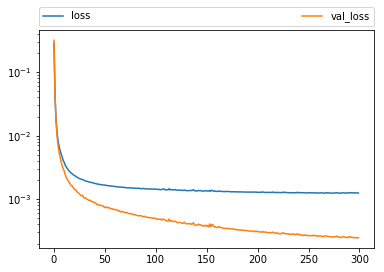

In [14]:
def mfield_partialvol(m_field, voxel_size=3):
    #return m_field
    return np.sign(m_field)*(np.abs(m_field)%voxel_size)

# %%

%run models/mocae.py
%run models/fconv_encoder.py

restore = False

model_path = "/scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt"

#ccae = inference_mocae()# multi-objective convolutional auto encoder
#ccae = inference_mocae_mul() # same w for encoder end decoder

with tf.device('/gpu:0'):
    #ccae = inference_fconv_small12()
    #ccae = inference_fconv(input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    ccae = inference_mocae_mul_ae(alpha=1.,input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    #ccae = inference_fconv_m2i(addmotion=True,alpha=1.,input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    #ccae = inference_fconv_small(alpha=1.,input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    #ccae = inference_fconv_supercompact()
    #ccae = inference_mocae_mul(alpha=1.,input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    #ccae = inference_mocae_samew_small(input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    #ccae = inference_mocae_multibranch()
    #ccae = inference_mocae_concat()
    #ccae = inference_2obj()
# %%
#learning_rate = 0.000001
learning_rate = 0.000001
decay=0.
momentum=0.9
epsilon=1e-08
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])
#optimizer_i = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_i'])
#optimizer_m = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_m'])

#optimizer = tf.train.AdamOptimizer().minimize(ccae['cost'])
#optimizer_i = tf.train.AdamOptimizer().minimize(ccae['loss_i'])
#optimizer_m = tf.train.AdamOptimizer().minimize(ccae['loss_m'])


#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(ccae['cost'])

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Restore model weights from previously saved model
if restore:
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)



# %%
# Fit all training data
hist_train_loss = []
hist_val_loss = []
hist_val_ref_loss = []
batch_size = 20
n_epochs = 300
#mean_data = (images[...,:,np.newaxis]/1000.).mean(0) 
#mean_target = (lr_vols[...,:,np.newaxis]/1000.).mean(0) 
for epoch_i in range(n_epochs):
    for batch_i in range(7000 // batch_size):
        #batch_xs, _ = mnist.train.next_batch(batch_size)
        #train = np.array([img - mean_img for img in batch_xs])
        #target = lr_vols[batch_i*batch_size:(batch_i+1)*batch_size,...,:10,np.newaxis]/100.
        train = images[batch_i*batch_size:(batch_i+1)*batch_size,...]#/1000.            
        #target -= mean_target
        #train -= mean_data
        motion = mfield_partialvol(m_field[batch_i*batch_size:(batch_i+1)*batch_size,...])

        #print train.shape, motion.shape
        sess.run([optimizer], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 0.9})
        #sess.run([optimizer_m], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1})
        
        
        #sess.run([optimizer], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: .7})
        #sess.run(optimizer, feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})
        
        if batch_i % 32 == 0:
            train_loss,train_lossi,train_lossm = sess.run([ccae['cost'],ccae['loss_i'],ccae['loss_m']], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
            print('Batch',batch_i,'Train loss',train_loss,train_lossi,train_lossm)
        
    # Validation
    #train = lr_vols_motion_cor[0:(799+1)*batch_size,...,:10,np.newaxis]/100.            
    #motion = motion_field[0:(799+1)*batch_size,...,:10,:]
    #train_loss, _ = batch_loss(train, motion)
    train_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
    train = images[10000:10010,...]#/1000.  
    #train = images[100:110,...]#/1000.  
    #train -= mean_data
    motion = mfield_partialvol(m_field[10000:10010,...])
    #motion = mfield_partialvol(m_field[100:110,...])
    #val_loss, _ = batch_loss(train, motion)
    val_loss = sess.run(ccae['cost'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})

    #target = lr_vols[800:900,...,:10,np.newaxis]/100.
    #target -= mean_target
    #val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: np.zeros_like(motion), ccae['t']: target, ccae['keep_prob']: 1.})
    #val_ref_loss = sess.run(ccae['loss_i'], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: target, ccae['keep_prob']: 1.})

    #hist_val_ref_loss.append(val_ref_loss)
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    print('Epoch',epoch_i)
    print('Train loss',train_loss, 'Val loss', val_loss)
    
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)

# %%
plt.figure()
ax=plt.subplot(111)
plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
   ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')
# Plot example reconstructions
n_examples = 10
test_xs_norm = images[0:150,...]#/1000.
motion_test = mfield_partialvol(m_field[0:150,...])
_, recon = batch_loss(test_xs_norm, motion_test)
#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
print(recon.shape)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})

# Close the Session when we're done.
#sess.close()

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

In [95]:
model_path = "/scratch/cdansereau/datasets/deepmotion/models/model_mocae_small.ckpt"

saver = tf.train.Saver()

# %%
# Save model weights to disk
save_path = saver.save(sess, model_path)
print("Model saved in file: %s" % model_path)

Model saved in file: /scratch/cdansereau/datasets/deepmotion/models/model_mocae_small.ckpt


In [26]:
import tensorflow as tf
def mfield_partialvol(m_field, voxel_size=3):
    #return m_field
    return np.sign(m_field)*(np.abs(m_field)%voxel_size)

# %%

%run models/mocae.py
%run models/fconv_encoder.py
#model_path = "/scratch/cdansereau/datasets/deepmotion/models/model_mocae_small.ckpt"

model_path = "/scratch/cdansereau/datasets/deepmotion/models/model_mocae_mul_ae_motion.ckpt"

with tf.device('/gpu:0'):
    #ccae = inference_fconv_small12()
    #ccae = inference_fconv(input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
    ccae = inference_mocae_mul_ae(alpha=1.,input_shape=[None, 64,64,32,1],input_shape_m=[None, 64,64,32,3])
learning_rate = 0.000001
decay=0.
momentum=0.9
epsilon=1e-08
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['cost'])
#optimizer_i = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_i'])
#optimizer_m = tf.train.RMSPropOptimizer(learning_rate,decay,momentum,epsilon).minimize(ccae['loss_m'])

#optimizer = tf.train.AdamOptimizer().minimize(ccae['cost'])
#optimizer_i = tf.train.AdamOptimizer().minimize(ccae['loss_i'])
#optimizer_m = tf.train.AdamOptimizer().minimize(ccae['loss_m'])


#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(ccae['cost'])

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# We create a session to use the graph
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())
# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Restore model weights from previously saved model

save_path = saver.restore(sess, model_path)
print("Model restored from file: %s" % save_path)

[<tf.Tensor 'gradients_13/split_7_grad/concat:0' shape=(?, 32, 32, 16, 256) dtype=float32>, None, None]


NotFoundError: Key deconv_motion_2_7/Variable/RMSProp_1 not found in checkpoint
	 [[Node: save_13/RestoreV2_823 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_13/Const_0, save_13/RestoreV2_823/tensor_names, save_13/RestoreV2_823/shape_and_slices)]]
	 [[Node: save_13/RestoreV2_861/_1377 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_9663_save_13/RestoreV2_861", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save_13/RestoreV2_823', defined at:
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-1d51ebf62ede>", line 45, in <module>
    saver = tf.train.Saver()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key deconv_motion_2_7/Variable/RMSProp_1 not found in checkpoint
	 [[Node: save_13/RestoreV2_823 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_13/Const_0, save_13/RestoreV2_823/tensor_names, save_13/RestoreV2_823/shape_and_slices)]]
	 [[Node: save_13/RestoreV2_861/_1377 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_9663_save_13/RestoreV2_861", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:

plt.figure()
ax=plt.subplot(111)
plt.plot(range(n_epochs),hist_train_loss,range(n_epochs),hist_val_loss)
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
   ncol=2, mode="expand", borderaxespad=0.)
ax.set_yscale('log')

In [18]:
def batch_loss(images, m_field, batch_size=5):
    stack_loss = []
    stack_y_hat = []
    for batch_i in range(images.shape[0] // batch_size):
        train = images[batch_i*batch_size:(batch_i+1)*batch_size,...]
        motion = m_field[batch_i*batch_size:(batch_i+1)*batch_size,...]

        #print train.shape, motion.shape
        val_loss, y_hat = sess.run([ccae['cost'], ccae['y']], feed_dict={ccae['x']: train, ccae['m']: motion, ccae['t']: train, ccae['keep_prob']: 1.})
        stack_loss.append(val_loss)
        stack_y_hat.append(y_hat)
        
    return np.vstack(stack_loss), np.vstack(stack_y_hat)


In [8]:

# Plot example reconstructions
n_examples = 10
test_xs_norm = images[10050:10150,...]#/1000.
motion_test = mfield_partialvol(m_field[10050:10150,...])

_, recon = batch_loss(test_xs_norm, motion_test)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
#print(recon.shape)
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})


ValueError: need at least one array to concatenate

In [15]:
test_xs_norm.max()

66.5

In [106]:
from deepmotion.utils.utility import *
def compute_corr3D(target, lr_vols_motion_cor, motion_params, motion_field):
    
    #target -= mean_target[np.newaxis,...,0]
    #lr_vols_motion_cor -= mean_data[np.newaxis,...,0]
    
    # create displacement field
    #motion_field = registration.displacement_field(np.eye(4),motion_params, target.shape[1:])%3.

    # compute deepmotion correction
    _, recon = batch_loss(lr_vols_motion_cor, motion_field)
    _, recon_cor = batch_loss(lr_vols_motion_cor, np.zeros_like(motion_field))
    #recon = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: motion_field, ccae['keep_prob']: 1.})
    #recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: lr_vols_motion_cor[...,np.newaxis], ccae['m']: np.zeros_like(motion_field), ccae['keep_prob']: 1.})
    
    results_data = []
    results_data.append(lr_vols_motion_cor)
    results_data.append(recon[...,0])
    results_data.append(recon_cor[...,0])
    
    # regress out the motion  
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    mask = (cor_map_ref==1)[0,...]
    residual = mass_univar_reg(ts_vol2vec(lr_vols_motion_cor,mask), simu3d.vexpension(motion_params))
    vol_motion_lincor = ts_vec2vol(residual,mask)
    
    # compute the correlations
    cor_map_ref = np.nan_to_num(corrmap3D(target,target))
    cor_map_lin = np.nan_to_num(corrmap3D(target,results_data[0]))
    cor_map_deep = np.nan_to_num(corrmap3D(target,results_data[1]))
    cor_map_lin_deep = np.nan_to_num(corrmap3D(results_data[0],results_data[1]))
    cor_map_zerom = np.nan_to_num(corrmap3D(target,results_data[2]))
    cor_map_lin_mparam_cor = np.nan_to_num(corrmap3D(target,vol_motion_lincor))
    
    # print the results
    print 'REF:',cor_map_ref[cor_map_ref!=0].mean(),cor_map_ref[cor_map_ref!=0].std()
    print 'cor_map_lin:',cor_map_lin[cor_map_ref!=0].mean(),cor_map_lin[cor_map_ref!=0].std()
    print 'cor_map_deep:',cor_map_deep[cor_map_ref!=0].mean(),cor_map_deep[cor_map_ref!=0].std()
    print 'cor_map_lin_deep:',cor_map_lin_deep[cor_map_ref!=0].mean(),cor_map_lin_deep[cor_map_ref!=0].std()
    print 'cor_map_zerom:',cor_map_zerom[cor_map_ref!=0].mean(),cor_map_zerom[cor_map_ref!=0].std()
    print 'cor_map_lin_mparam_cor:', cor_map_lin_mparam_cor[cor_map_ref!=0].mean(),cor_map_lin_mparam_cor[cor_map_ref!=0].std()
    
    return {'cor_map_ref':cor_map_ref, 
            'cor_map_lin':cor_map_lin, 
            'cor_map_deep':cor_map_deep, 
            'cor_map_lin_deep':cor_map_lin_deep, 
            'cor_map_zerom':cor_map_zerom, 
            'cor_map_lin_mparam_cor':cor_map_lin_mparam_cor,
            'vol_motion':results_data[0],
            'vol_motion_deep':results_data[1],
            'vol_motion_deepcor':results_data[2],
            'vol_motion_lincor':vol_motion_lincor,
            'target':target}
    


In [107]:
compute_corr3D[results_data[0],results_data[1],results_data[2],motion_params[900:950,:], m_field[900:950,...]]

TypeError: 'function' object has no attribute '__getitem__'

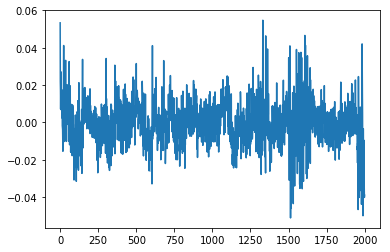

In [16]:
plt.figure()
plt.plot(images[:2000,25,20,17,0])

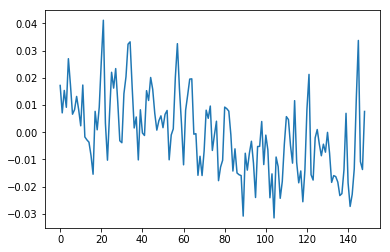

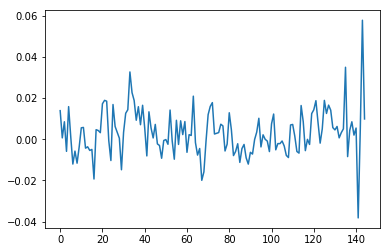

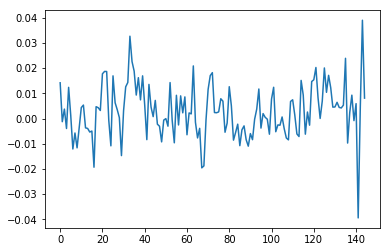

In [24]:
plt.figure()
plt.plot(results_data[0][:,25,20,17,0])
plt.figure()
plt.plot(results_data[1][:,25,20,17,0])
plt.figure()
plt.plot(results_data[2][:,25,20,17,0])

In [19]:

# Plot example reconstructions
n_examples = 10
test_xs_norm = images[10150:10250,...]#/1000.
motion_test = mfield_partialvol(m_field[10150:10250,...])

_, recon = batch_loss(test_xs_norm, motion_test)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
#print(recon.shape)
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})


In [23]:

# Plot example reconstructions
n_examples = 10
test_xs_norm = images[1:150,...]#/1000.
motion_test = mfield_partialvol(m_field[1:150,...])

_, recon = batch_loss(test_xs_norm, motion_test)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
#print(recon.shape)
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})


In [22]:

# Plot example reconstructions
n_examples = 10
test_xs_norm = images[300:450,...]#/1000.
motion_test = mfield_partialvol(m_field[300:450,...])

_, recon = batch_loss(test_xs_norm, motion_test)
_, recon_cor = batch_loss(test_xs_norm, np.zeros_like(motion_test))

results_data = [test_xs_norm, recon, recon_cor, {'train_loss':hist_train_loss,'val_loss':hist_val_loss, 'model': ccae}]

#recon = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: motion_test, ccae['keep_prob']: 1.})
#print(recon.shape)
#recon_cor = sess.run(ccae['y'], feed_dict={ccae['x']: test_xs_norm, ccae['m']: np.zeros_like(motion_test), ccae['keep_prob']: 1.})


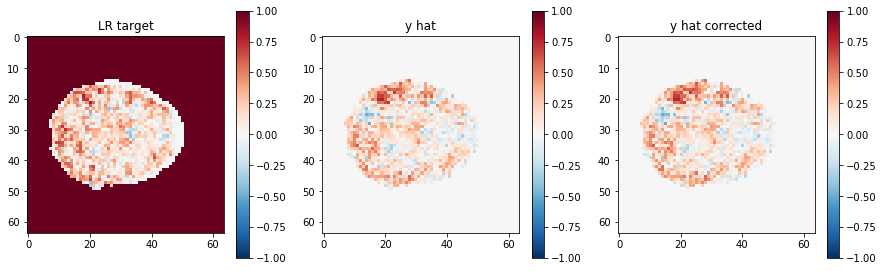

In [25]:
def get_seed_cor_map(vols, mask_roi=[]):
    # seed
    if mask_roi != []:
        seed = ts_vol2vec(vols,mask_roi).mean(1)[:,np.newaxis]
    else:
        #seed = vols[:,27:33,17:22,15,np.newaxis].mean(1).mean(1)
        seed = vols[:,17:23,20:22,15:17,np.newaxis].mean(1).mean(1).mean(1)
        
    time_series = np.hstack((seed,vols[...,17].reshape((vols.shape[0],vols.shape[1]*vols.shape[2])))).T
    cor_map_ = np.corrcoef(time_series)[0,1:].reshape((vols.shape[1],vols.shape[2]))
    return np.nan_to_num(cor_map_)

plt.figure(figsize=(15,10))
cor_map_ = get_seed_cor_map(results_data[0][:,...,0])
plt.subplot(2,3,1)
plt.title('LR target')
ref_corr_map = cor_map_.copy()
cor_map_[np.abs(ref_corr_map)==0]=10
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()
cor_map_ = get_seed_cor_map(results_data[1][:,...,0])
plt.subplot(2,3,2)
plt.title('y hat')
cor_map_[ref_corr_map==0]=0
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()
cor_map_ = get_seed_cor_map(results_data[2][:,...,0])
plt.subplot(2,3,3)
plt.title('y hat corrected')
cor_map_[ref_corr_map==0]=0
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()

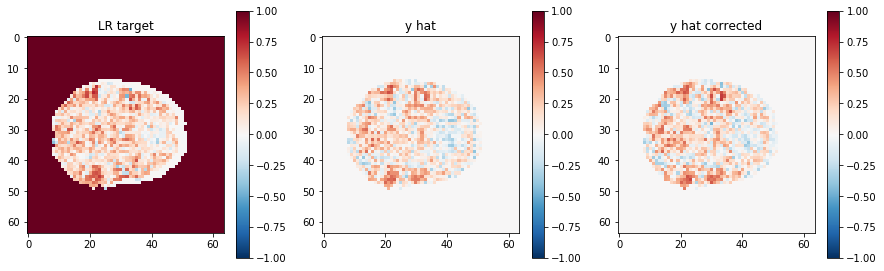

In [190]:
def get_seed_cor_map(vols, mask_roi=[]):
    # seed
    if mask_roi != []:
        seed = ts_vol2vec(vols,mask_roi).mean(1)[:,np.newaxis]
    else:
        #seed = vols[:,27:33,17:22,15,np.newaxis].mean(1).mean(1)
        seed = vols[:,17:23,20:22,15:17,np.newaxis].mean(1).mean(1).mean(1)
        
    time_series = np.hstack((seed,vols[...,15].reshape((vols.shape[0],vols.shape[1]*vols.shape[2])))).T
    cor_map_ = np.corrcoef(time_series)[0,1:].reshape((vols.shape[1],vols.shape[2]))
    return np.nan_to_num(cor_map_)

plt.figure(figsize=(15,10))
cor_map_ = get_seed_cor_map(results_data[0][:,...,0])
plt.subplot(2,3,1)
plt.title('LR target')
ref_corr_map = cor_map_.copy()
cor_map_[np.abs(ref_corr_map)==0]=10
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()
cor_map_ = get_seed_cor_map(results_data[1][:,...,0])
plt.subplot(2,3,2)
plt.title('y hat')
cor_map_[ref_corr_map==0]=0
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()
cor_map_ = get_seed_cor_map(results_data[2][:,...,0])
plt.subplot(2,3,3)
plt.title('y hat corrected')
cor_map_[ref_corr_map==0]=0
plt.imshow(np.nan_to_num(cor_map_),cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1,interpolation='none')
plt.colorbar()

/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


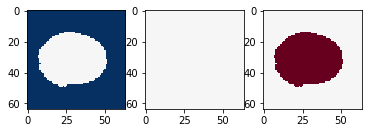

In [37]:
cor_map_1 = np.abs(get_seed_cor_map(results_data[0][:,...,0]))>0
cor_map_1 = cor_map_1.astype(int)
cor_map_2 = np.abs(get_seed_cor_map(results_data[1][:,...,0]))>0
cor_map_2 = cor_map_2.astype(int)

plt.subplot(131)
plt.imshow(cor_map_1,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')
plt.subplot(132)
plt.imshow(cor_map_2,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')
plt.subplot(133)
plt.imshow(cor_map_1+cor_map_2,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')

/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/scratch/cdansereau/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


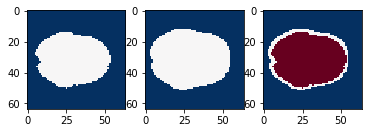

In [167]:
cor_map_1 = np.abs(get_seed_cor_map(results_data[0][:,...,0]))>0
cor_map_1 = cor_map_1.astype(int)
cor_map_2 = np.abs(get_seed_cor_map(results_data[1][:,...,0]))>0
cor_map_2 = cor_map_2.astype(int)

plt.subplot(131)
plt.imshow(cor_map_1,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')
plt.subplot(132)
plt.imshow(cor_map_2,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')
plt.subplot(133)
plt.imshow(cor_map_1+cor_map_2,cmap=plt.get_cmap('RdBu_r'),vmin=0,vmax=2,interpolation='none')

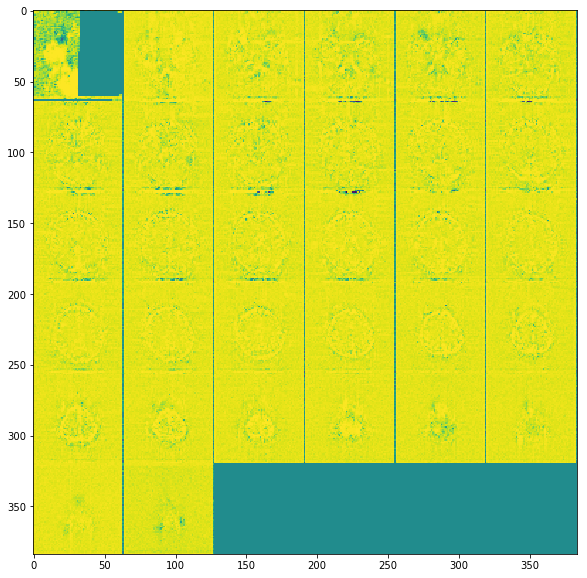

In [47]:
from deepmotion.utils.utility import *
cor_map = corrmap3D(results_data[0][...,0],results_data[2][...,0])
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(cor_map[0,...]))

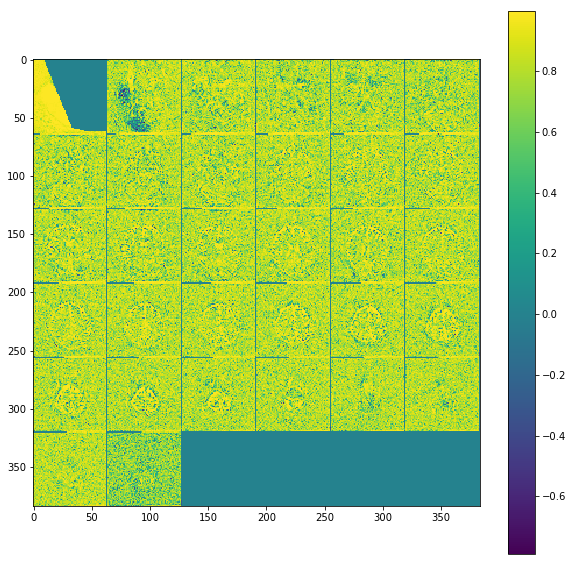

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(cor_map[0,...]))
plt.colorbar()

In [27]:
results_data[2].max()

0.099667616

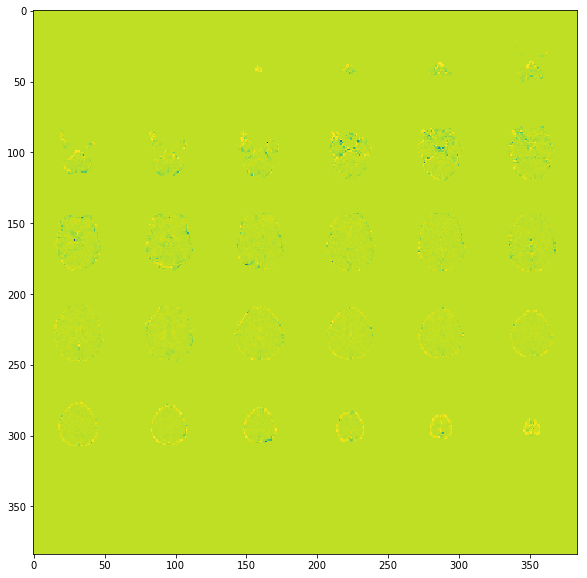

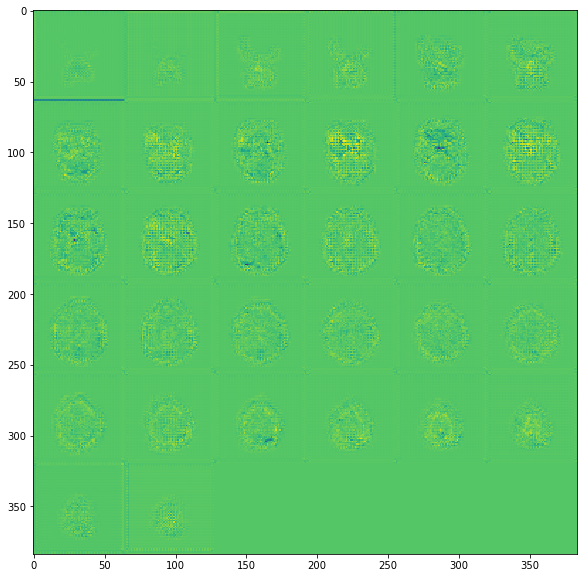

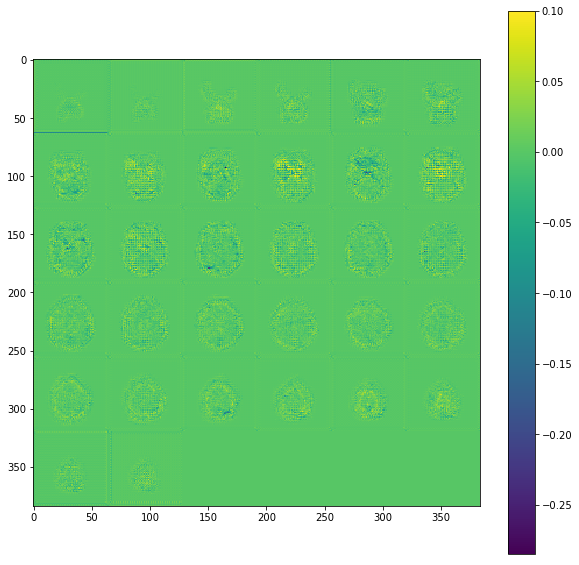

In [158]:
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[0][10,...,0]),vmax=0.1)
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[1][10,...,0]),vmax=0.1)
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(results_data[2][10,...,0]),vmax=0.1)
plt.colorbar()

In [ ]:
res_stats = compute_corr3D(sim_s1['lr_vols'][...,:10]/100.,
              sim_s1['lr_vols_motion_cor'][...,:10]/100.,
              sim_s1['motion_params'])

plt.figure(figsize=(9,3))
plt.subplot(1,4,1)
plt.imshow(res_stats['target'][10,:,:,5],interpolation='None')
plt.subplot(1,4,2)
plt.imshow(res_stats['vol_motion'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,3)
plt.imshow(res_stats['vol_motion_deep'][10,:,:,5],interpolation='None',vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(res_stats['vol_motion_deepcor'][10,:,:,5],interpolation='None',vmin=0, vmax=1)


In [12]:
sess.close()